# Servo hydraulic actuator

Notebook for design of mechanism to provide control of pressure in a closed hydraulic system

Motor -> mechanical drive -> master cylinder

## Components
### Motor:
 - Brushed DC motor
 - Voltage limit on controller
 - Simulation of transient thermal characteristics based off motor supplier data

### Mechanical Drive:
 - Gearbox
 - Rotary to linear mechanism

### Hydraulic system
- Stiffness represented as a linear spring based on master cylinder travel

### Controller
- Simple PI controller controlling pressure by varying motor voltage

## Assumptions
- Winding resistance change with temperature is ignored. This will over-estimate performance of motor at continuous / heavy use
- Non-linear (detailed entrained / dissolved air) behaviour of fluid ignored. Low pressure behaviour of fluid will be inaccurate

In [1]:
import sympy
from sympy import *
import control as ct
import matplotlib.pyplot as plt
from math import pi
import numpy as np
import scipy as sp
init_printing()
plt.style.use('style.mplstyle')

# Parameters

In [2]:
#Mechanical parameters
lead = 15 / (2*pi) # mm/rad
n = 26 # gbox reduction
MR = lead / n # mm/rad
eff = .75*.9 # efficiency

#Hydraulic parameters
k_hyd_lin = 14.28 #bar/mm
k_hyd = k_hyd_lin * MR #bar/rad
A = (pi * 12**2) / 4 #mm2 (piston area)

#Motor characteristics
k_T = 42.9e-3 #Nm/A
l_a = 0.514e-3 #H
r_a = 2.95 #ohm

#Reflected inertia at motor
j_rotor = 21.2e-7 + 3.9e-7 + 32.6e-7 / n**2 #kg/m2
#Viscous damping at motor
b = 0 # Nm/(rad/s)

#Thermal characteristics
r_w = 3.01 #K/W
r_h = 10.2  #K/W
C_w = 23.8 / 3.01 #J/K
C_h = 620 / 10.2 #J/K

#Pressure controller
K_p_p = 15
K_i_p = K_p_p/10
K_d_p = 0

# #Current controller
# K_p_i = 5
# K_i_i = 0
# K_d_i = 0

#Limtis
U_max = 40 #V

#Other
T_ambient = 25 #deg
alpha_cu = 0.0039 

# Transfer functions

In [3]:
# Motor tfs
tf_circ = ct.tf(
    1,
    [l_a, r_a],
    inputs = 'u_a',
    outputs = 'i',
    name = 'circ',
)

tf_i = ct.tf(
    k_T,
    1,
    inputs = 'i',
    outputs = 'motor_torque',
    name = 'torque_gain',
)

tf_fb_torque = ct.tf(
    1e-3 * 0.1 * A * MR ,
    1,
    inputs = 'pressure',
    outputs = 'fb_torque',
    name = 'fb_torque',
)

tf_load = ct.tf(
    1,
    [j_rotor, b],
    inputs = 'eff_torque',
    outputs = 'omega',
    name = 'load',
)

tf_theta = ct.tf(
    1,
    [1,0],
    inputs = 'omega',
    outputs = 'theta',
    name = 'posn_integrator',
)

tf_emf = ct.tf(
    k_T,
    1,
    inputs = 'omega',
    outputs = 'u_emf',
    name = 'emf_gain'
)

tf_pressure = ct.tf(
    k_hyd,
    1,
    inputs = 'theta',
    outputs = 'pressure',
    name = 'pressure_gain',
)

volts = ct.summing_junction(
    ['u_s','-u_emf'],
    'u_a',
    name = 'sum',
)

torque_sum = ct.summing_junction(
    ['motor_torque', '-fb_torque'],
    'sum_torque',
    name = 'torque_sum',
)

tf_torque_eff = ct.tf(
    eff,
    1,
    inputs = 'sum_torque',
    outputs = 'eff_torque',
    name = 'efficiency',
)

In [4]:
#Controller tfs
pressure_controller = ct.tf(
    [K_p_p, K_i_p],
    [1, 0],
    inputs = 'e_p',
    outputs = 'u',
    name  = 'pressure_controller',
)

pressure_error = ct.summing_junction(
    ['pressure_set','-pressure'],
    'e_p',
    name = 'pressure_feedback',
)

# current_controller = ct.tf(
#     [K_p_i, K_i_i],
#     [1, 0],
#     inputs = 'e_i',
#     outputs = 'u',
#     name  = 'current_controller',
# )

# current_error = ct.summing_junction(
#     ['i_set','-i'],
#     'e_i',
#     name = 'current_error',
# )

# Nonlinear functions

In [5]:
#Misc fns
def sat_ud(t,x,u,params):
    return x

def sat_out(t,x,u,params):
    if u > params["max"]:
        return params["max"]
    if u < params["min"]:
        return params["min"]
    return u

u_sat = ct.nlsys(
    sat_ud,
    sat_out,
    inputs = 'u',
    outputs = 'u_s',
    states=1,
    name = 'saturate',
    params = {
        "max": U_max,
        "min": -U_max,
    }
)


# Root locus

Gives an idea of system performance under the proportional control, by visualising where the poles of the system have moved to with our proportional gain

Requires system to be linearised (not much issue in this case as only non-linear feature is voltage saturation, which should be avoided anyway). Doesn't take integral or derivative gains into account currently.

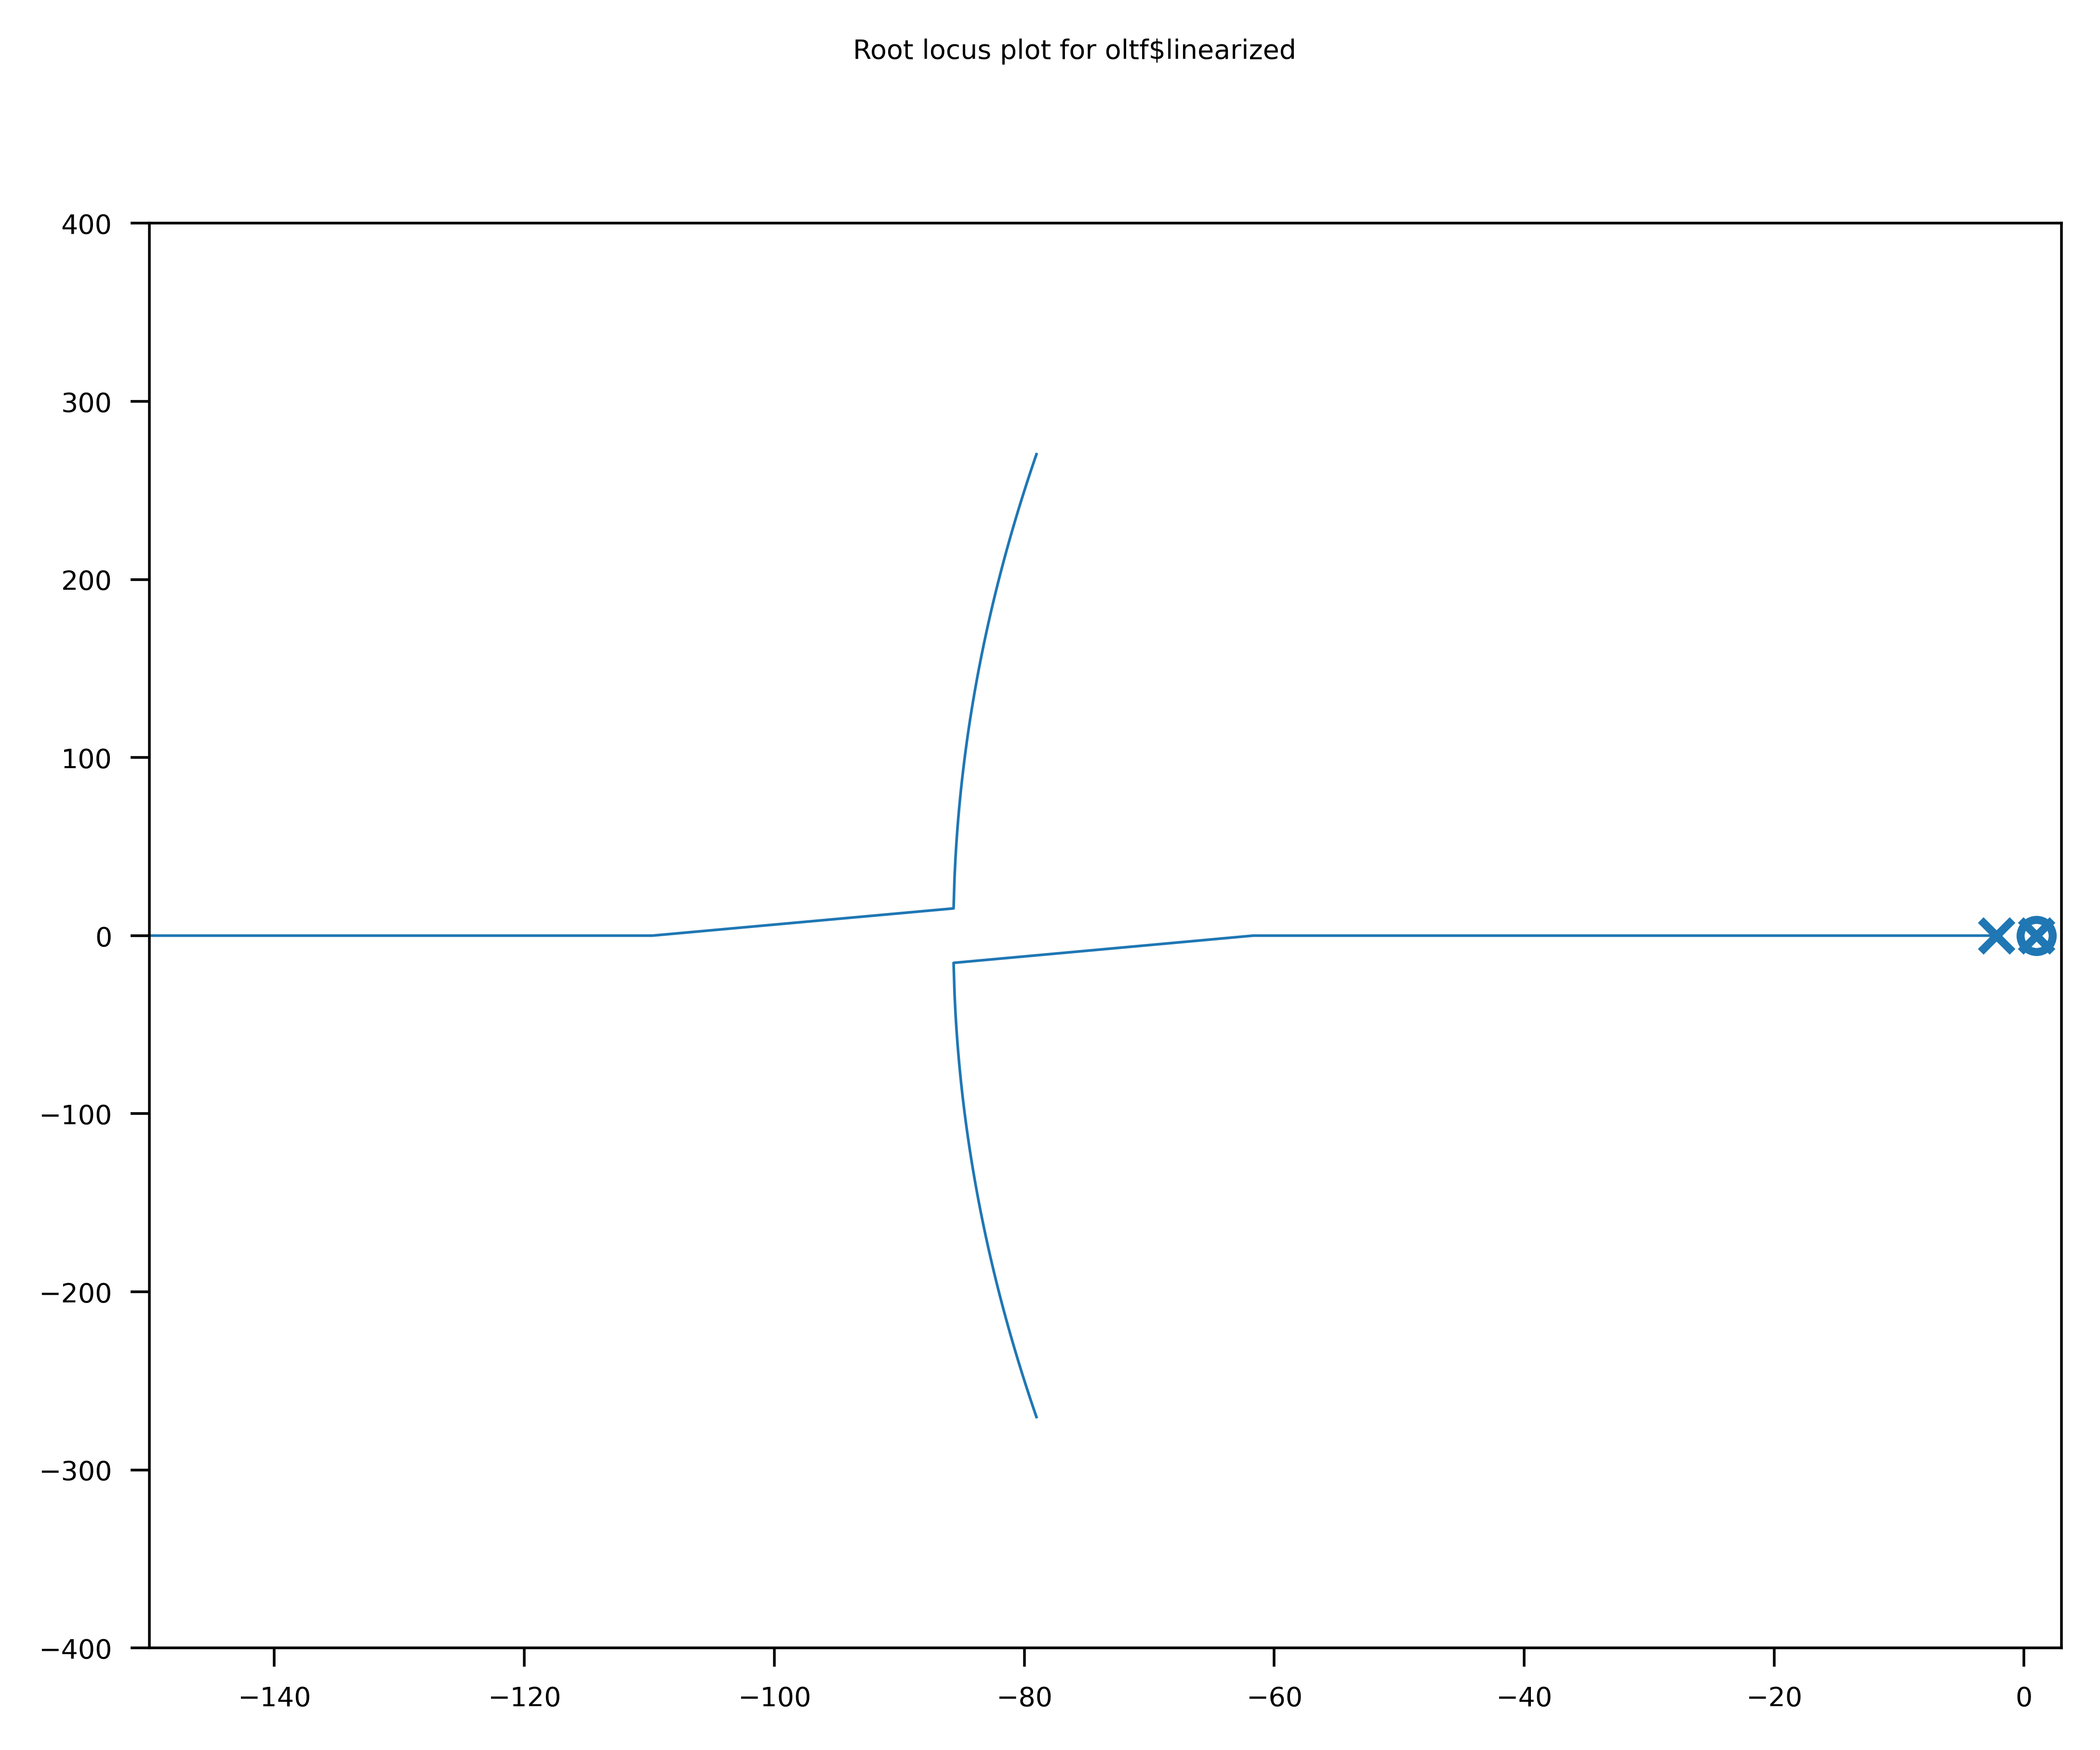

In [6]:
oltf = ct.interconnect([tf_circ, tf_i, tf_load, tf_emf, volts,
                       # pressure_controller, pressure_error, current_controller, current_error,
                       u_sat,
                       tf_theta, tf_pressure, torque_sum, tf_torque_eff, tf_fb_torque], # 
                    inputs = ['u'],
                    outputs = ['pressure'],    
                    name = 'oltf',
)
eq = ct.find_eqpt(oltf, [1,1,1,1],20)
oltf_lin = ct.linearize(oltf,eq[0],20,copy_names=True)
plt.gca().axis('auto')
ct.root_locus(oltf_lin,xlim = (-150,3),ylim=(-400,400), gains = np.linspace(0,K_p_p,100))

# Simulate system
Connect the system transfer functions, create input demand signals of interest, and simulate the time response of closed loop system.

In [7]:
output_list = ['pressure','i','u_s', 'omega', 'theta',]
sys = ct.interconnect([tf_circ, tf_i, tf_load, tf_emf, volts,
                       pressure_controller, pressure_error, #current_controller, current_error,
                       u_sat,
                       tf_theta, tf_pressure, torque_sum, tf_torque_eff, tf_fb_torque], #
                    inputs = ['pressure_set'],
                    outputs = output_list,    
                    name = 'motor',
)

sys.connection_table(show_names=True)

signal    | source                        | destination
--------------------------------------------------------------------------
sum_torque| torque_sum                    | efficiency                    
fb_torque | fb_torque                     | torque_sum                    
theta     | posn_integrator               | output, pressure_gain         
omega     | load                          | output, emf_gain, posn_inte.. 
u         | pressure_controller           | saturate                      
i         | circ                          | output, torque_gain           
motor_torque| torque_gain                   | torque_sum                    
e_p       | pressure_feedback             | pressure_controller           
u_s       | saturate                      | output, sum                   
pressure_set| input                         | pressure_feedback             
eff_torque| efficiency                    | load                          
pressure  | pressure_gain               

In [8]:
#Input functions
def const_value(C, start,end):
    eps = 1e-4
    t = np.linspace(start, end-eps,1000)
    u = C * np.ones(len(t))
    return [t,u]

def sinusoid(A,f,phi,U,start,end):
    eps = 1e-4
    t = np.linspace(start, end-eps,1000)
    u = A * np.sin(f*2*np.pi*(t-start) - np.radians(phi)) + U
    return [t,u]

peak_pressure = 66 #Bar
sin_amp = 5 #bar
sin_freq = 15 #Hz

on_time = 4
cooling_time = 60*5

# List of inputs, in form [t,u] where u is demand signal. Simulating a step, then an oscillation around a mean value, then 0 input to capture cooling behaviour
inp_list = [
    const_value(peak_pressure, 0, 0.2),
    sinusoid(sin_amp, sin_freq, -90, peak_pressure - sin_amp, 0.2, on_time),
    const_value(0,on_time, on_time + 0.2), # this is its own so solver puts small enough timestep to capture
    const_value(0 , on_time + 0.2, cooling_time),
]

In [9]:
states = 0
y = None
t = None
u = None
#Much more efficeint to split out into multiple sims, especailly with long periods of nothing happening in some inputs, and some with high frequency demand
for inp in inp_list:
    r = ct.input_output_response(sys,inp[0], inp[1], solve_ivp_method = 'LSODA', X0=states,)#solve_ivp_kwargs={'rtol': 1e-6, 'atol': 1e-9})
    t = np.concatenate((t,r.t)) if t is not None else r.t
    u = np.concatenate((u, r.u), axis = 1) if u is not None else r.u
    y = np.concatenate((y, r.y), axis = 1) if y is not None else r.y
    states = [s[-1] for s in r.x]
# print(y.shape)
# print(t.shape)
# print(u.shape)

## Plots

RMS current is 61.13A


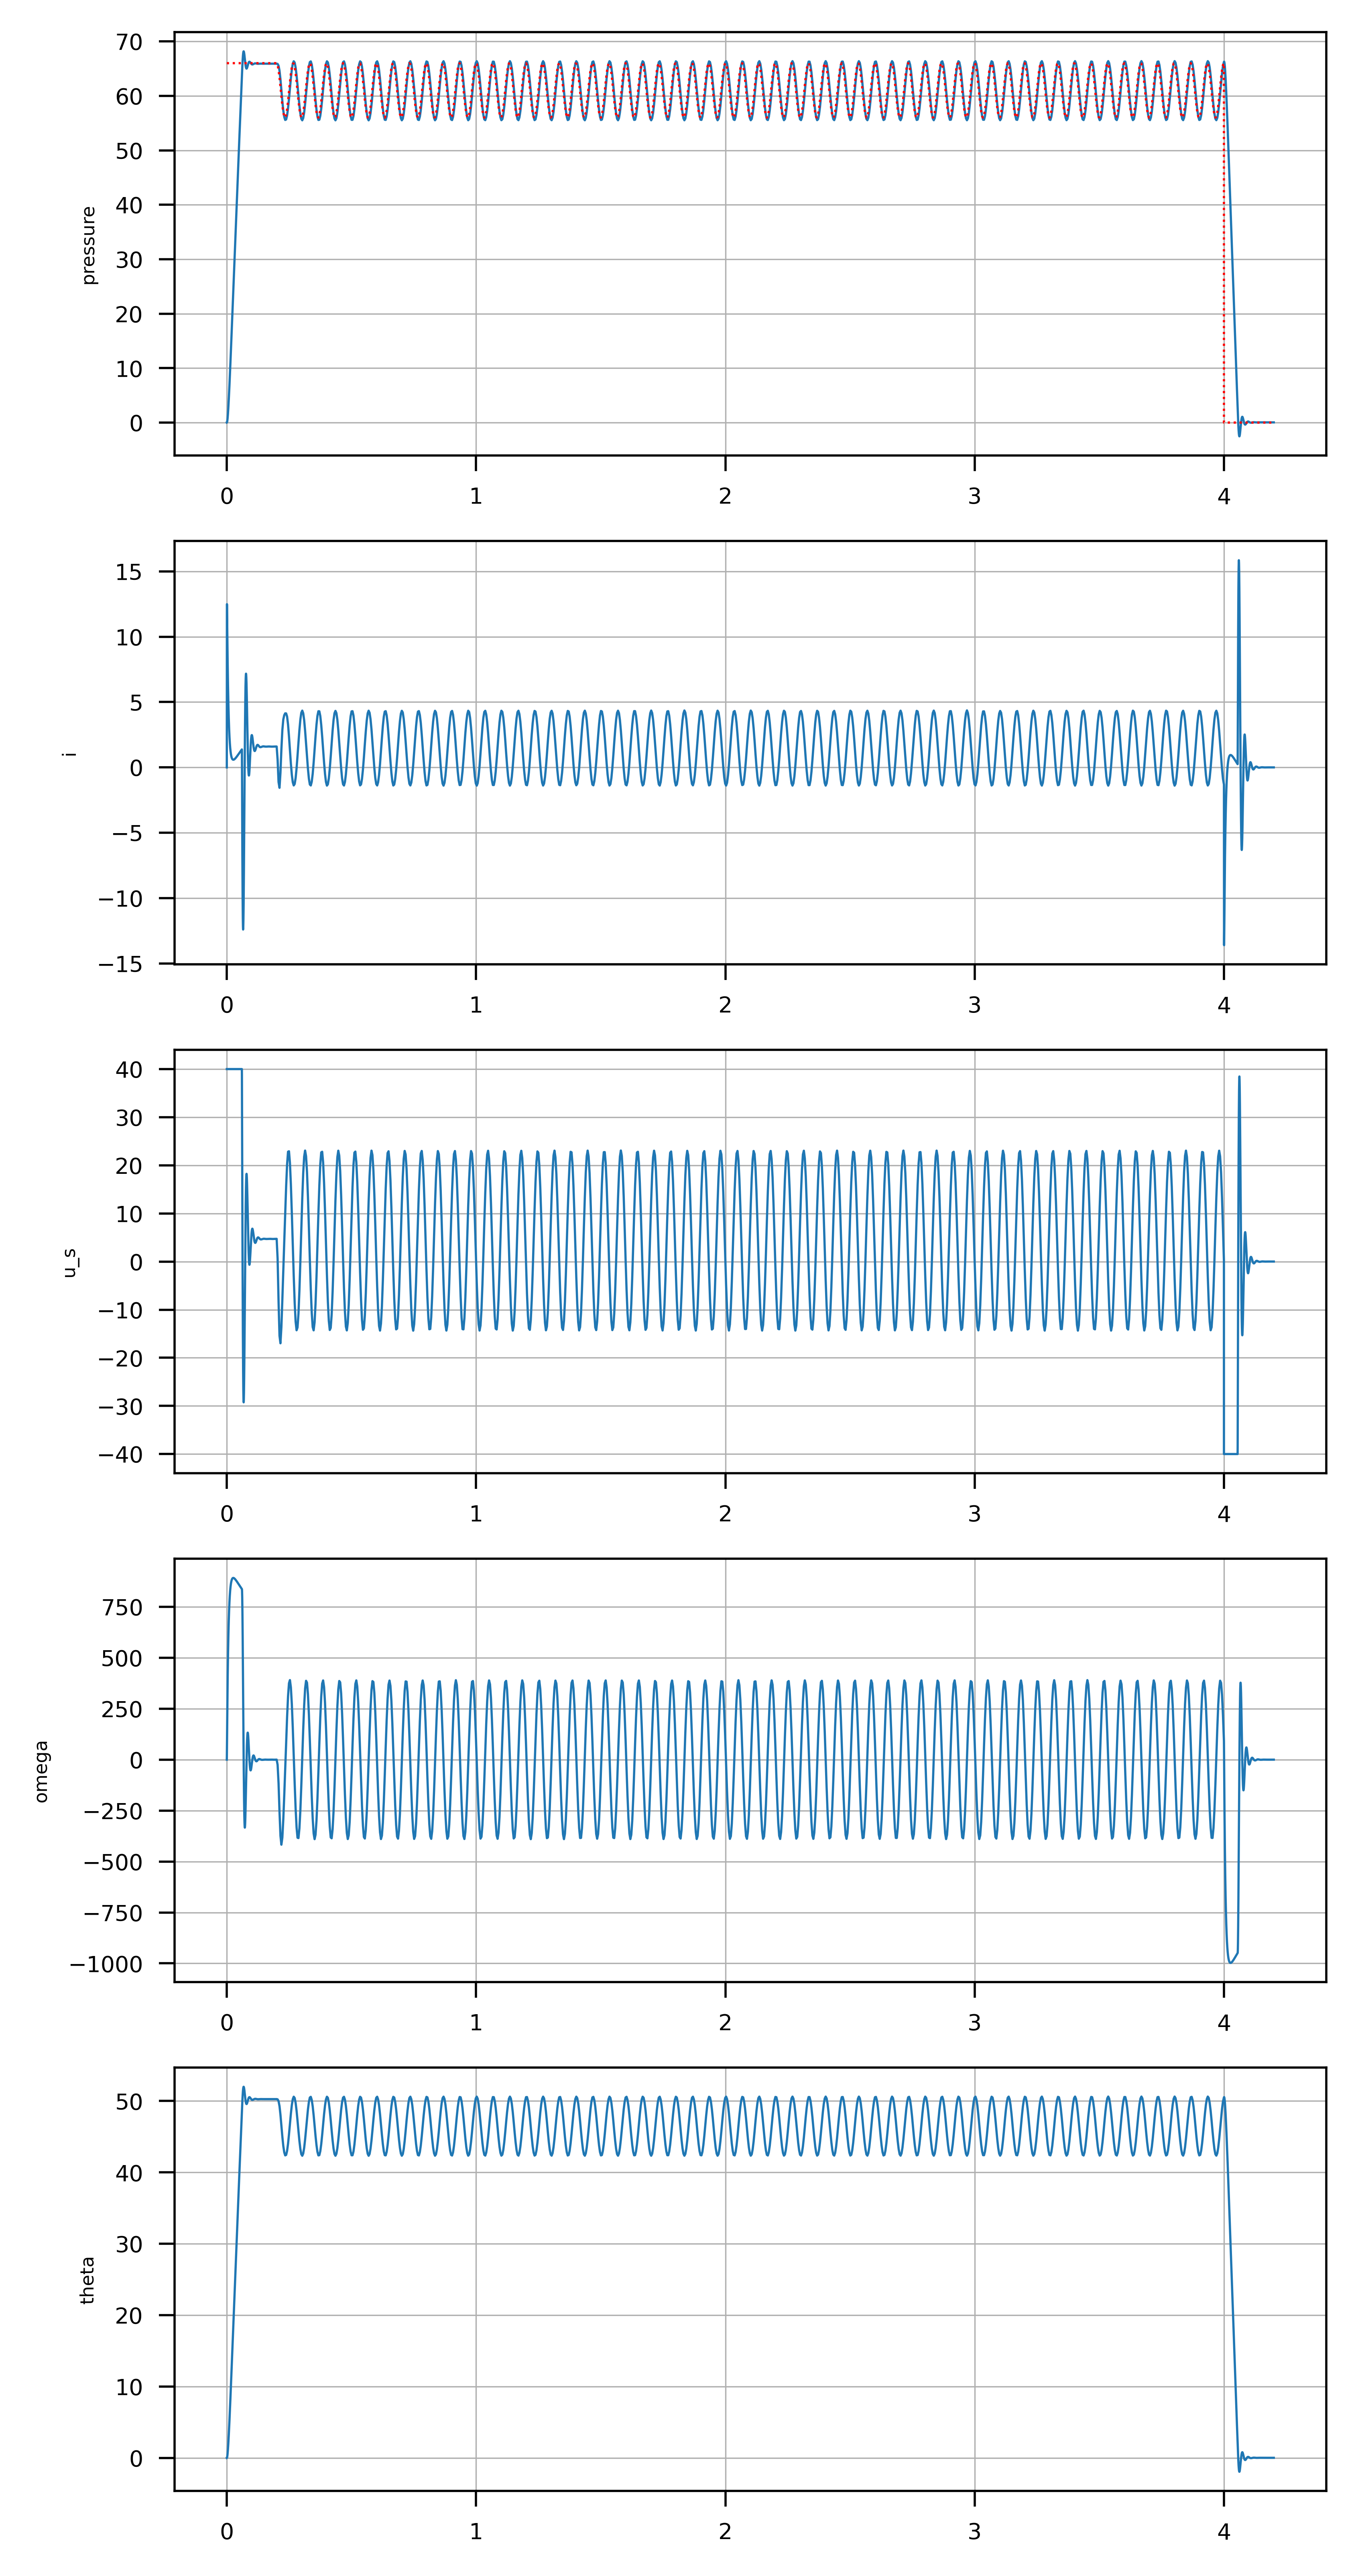

In [10]:
fig, axs = plt.subplots(len(output_list), figsize = (4,8))
fig.tight_layout()
idx = np.searchsorted(t,on_time*1.1)
for i, ax in enumerate(axs):
    ax.plot(t[0:idx],y[i][0:idx], label = output_list[i])
    ax.set_ylabel(output_list[i])
    ax.grid(True)
axs[0].plot(t[0:idx],np.transpose(u)[0:idx], linestyle = 'dotted', color = 'red')
rms = np.sqrt((1/on_time)* sp.integrate.trapezoid(y[0][0:idx]**2,t[0:idx]))
print(f"RMS current is {rms:.02f}A")

RMS current is 0.71A


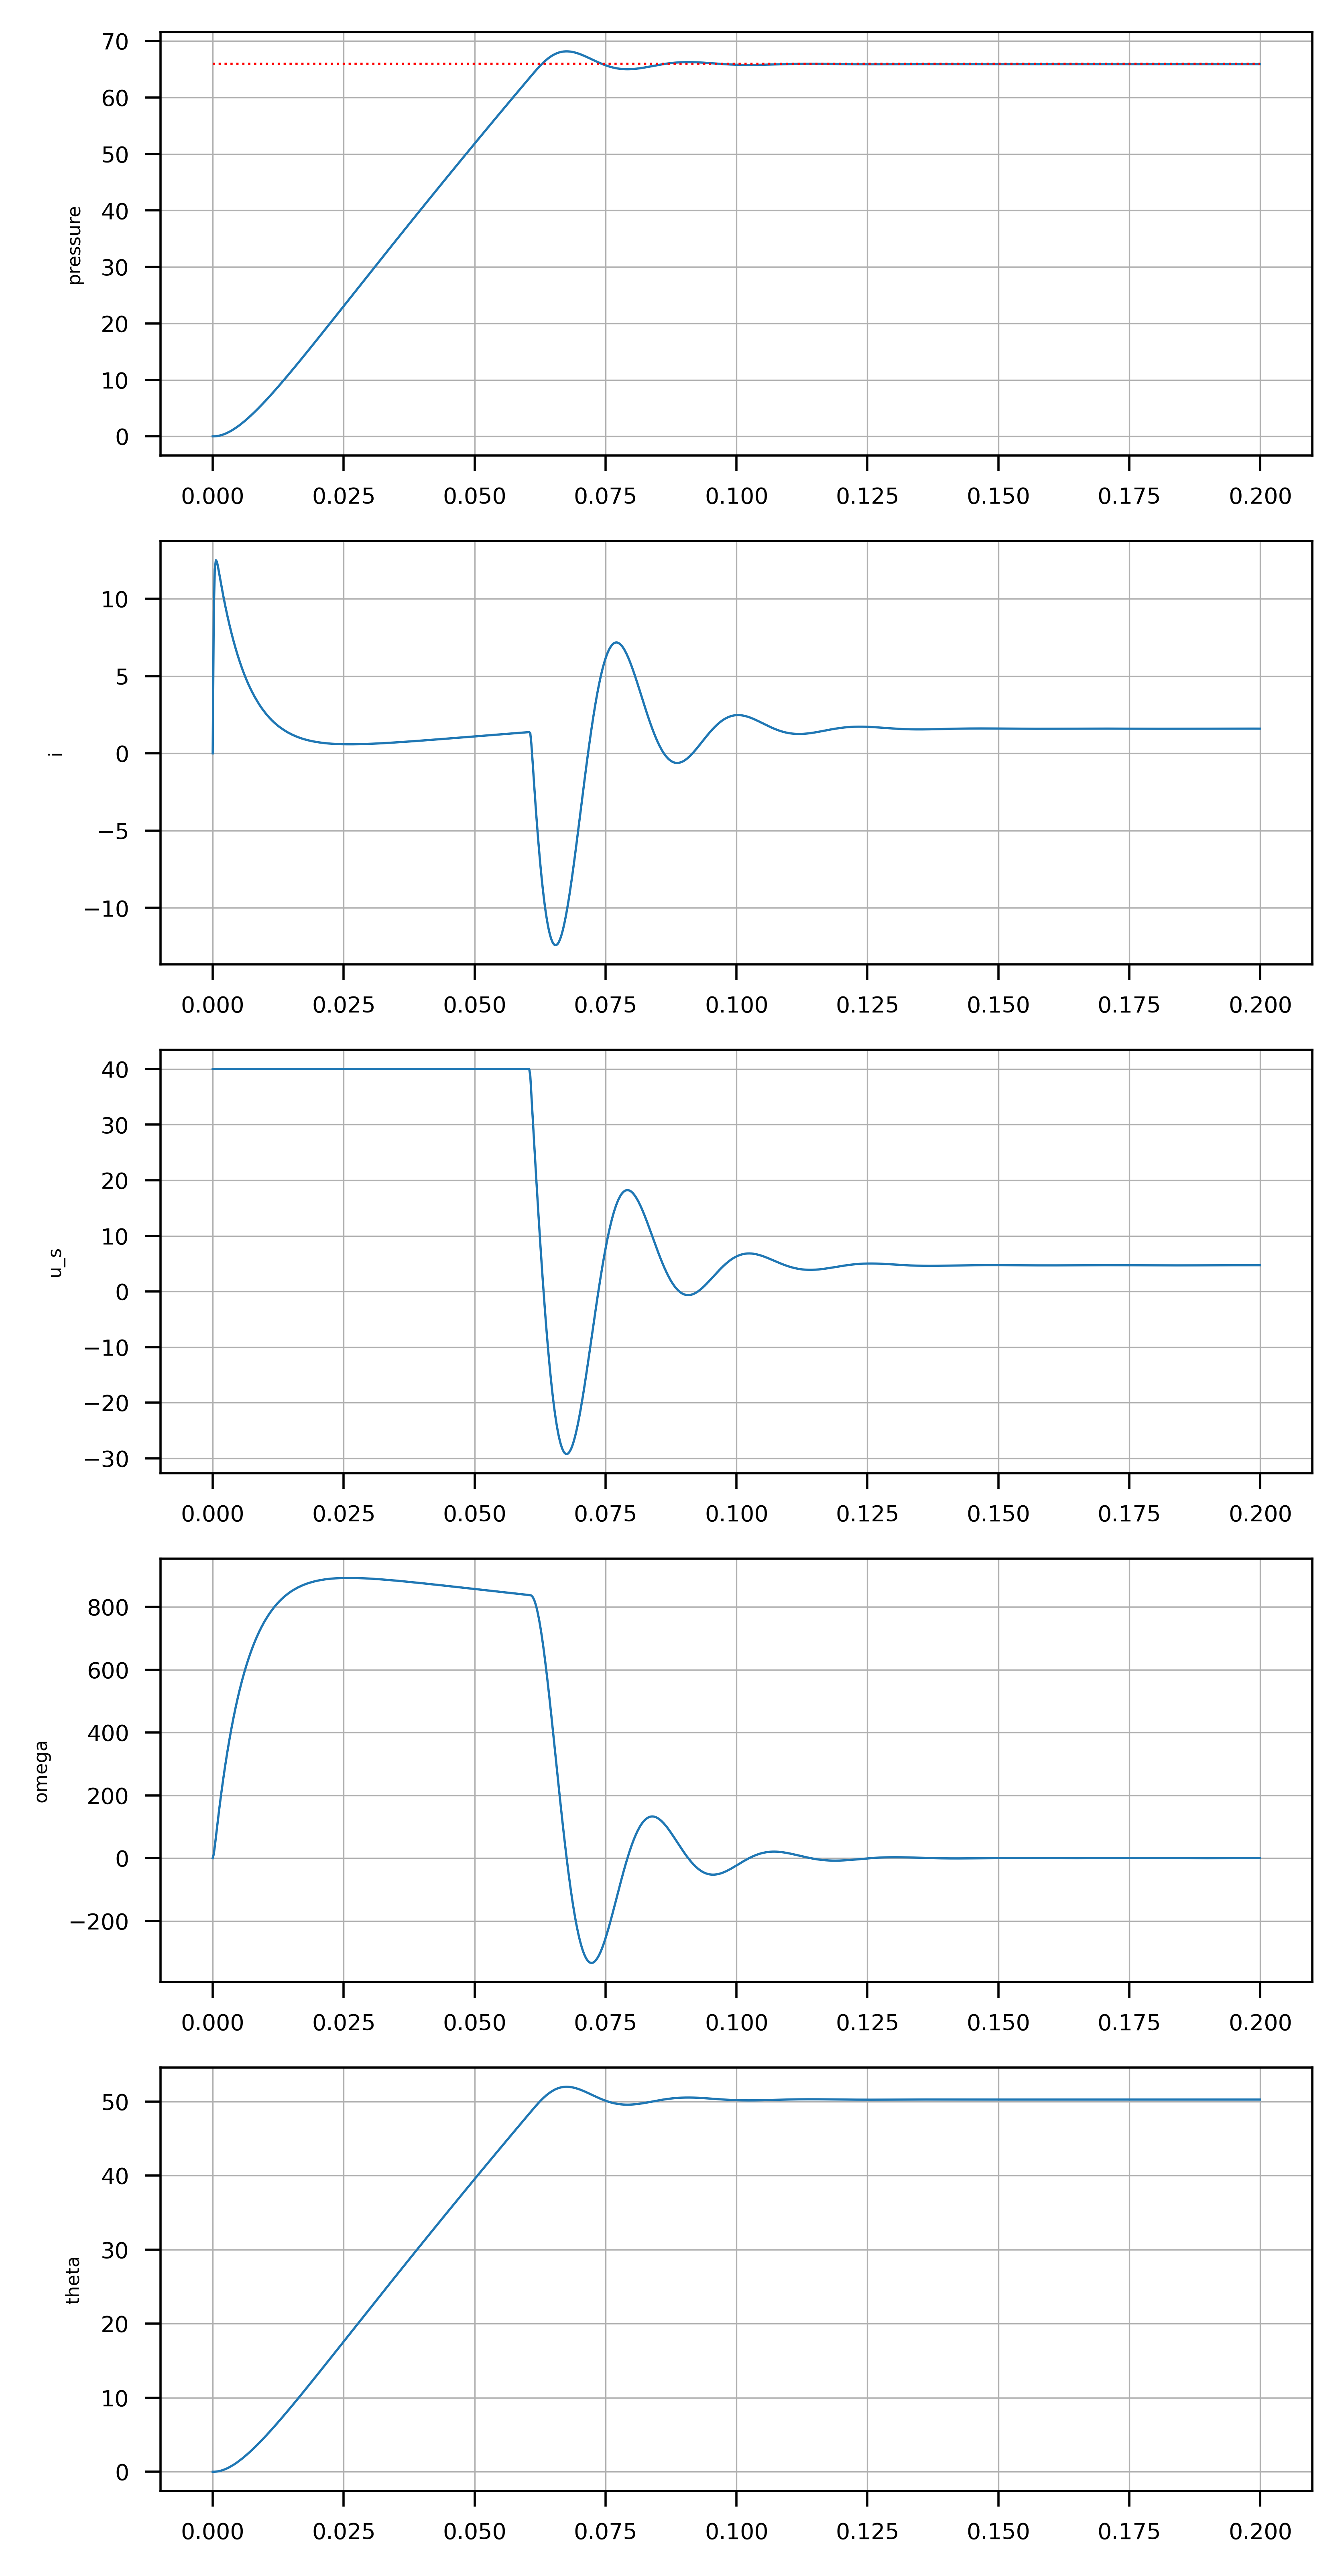

In [11]:
fig, axs = plt.subplots(len(output_list), figsize = (4,8))
fig.tight_layout()
idx = np.searchsorted(t,.2)
for i, ax in enumerate(axs):
    ax.plot(t[0:idx],y[i][0:idx], label = output_list[i])
    ax.set_ylabel(output_list[i])
    ax.grid(True)
axs[0].plot(t[0:idx],np.transpose(u)[0:idx], linestyle = 'dotted', color = 'red')
rms = np.sqrt((1/on_time)* sp.integrate.trapezoid(y[1][0:idx]**2,t[0:idx]))
print(f"RMS current is {rms:.02f}A")

# Motor State Space
Visualisation of speed torque space of motor. Can see that motion stays (pretty much) within motor speed torque lines in +ve and -ve quadrants

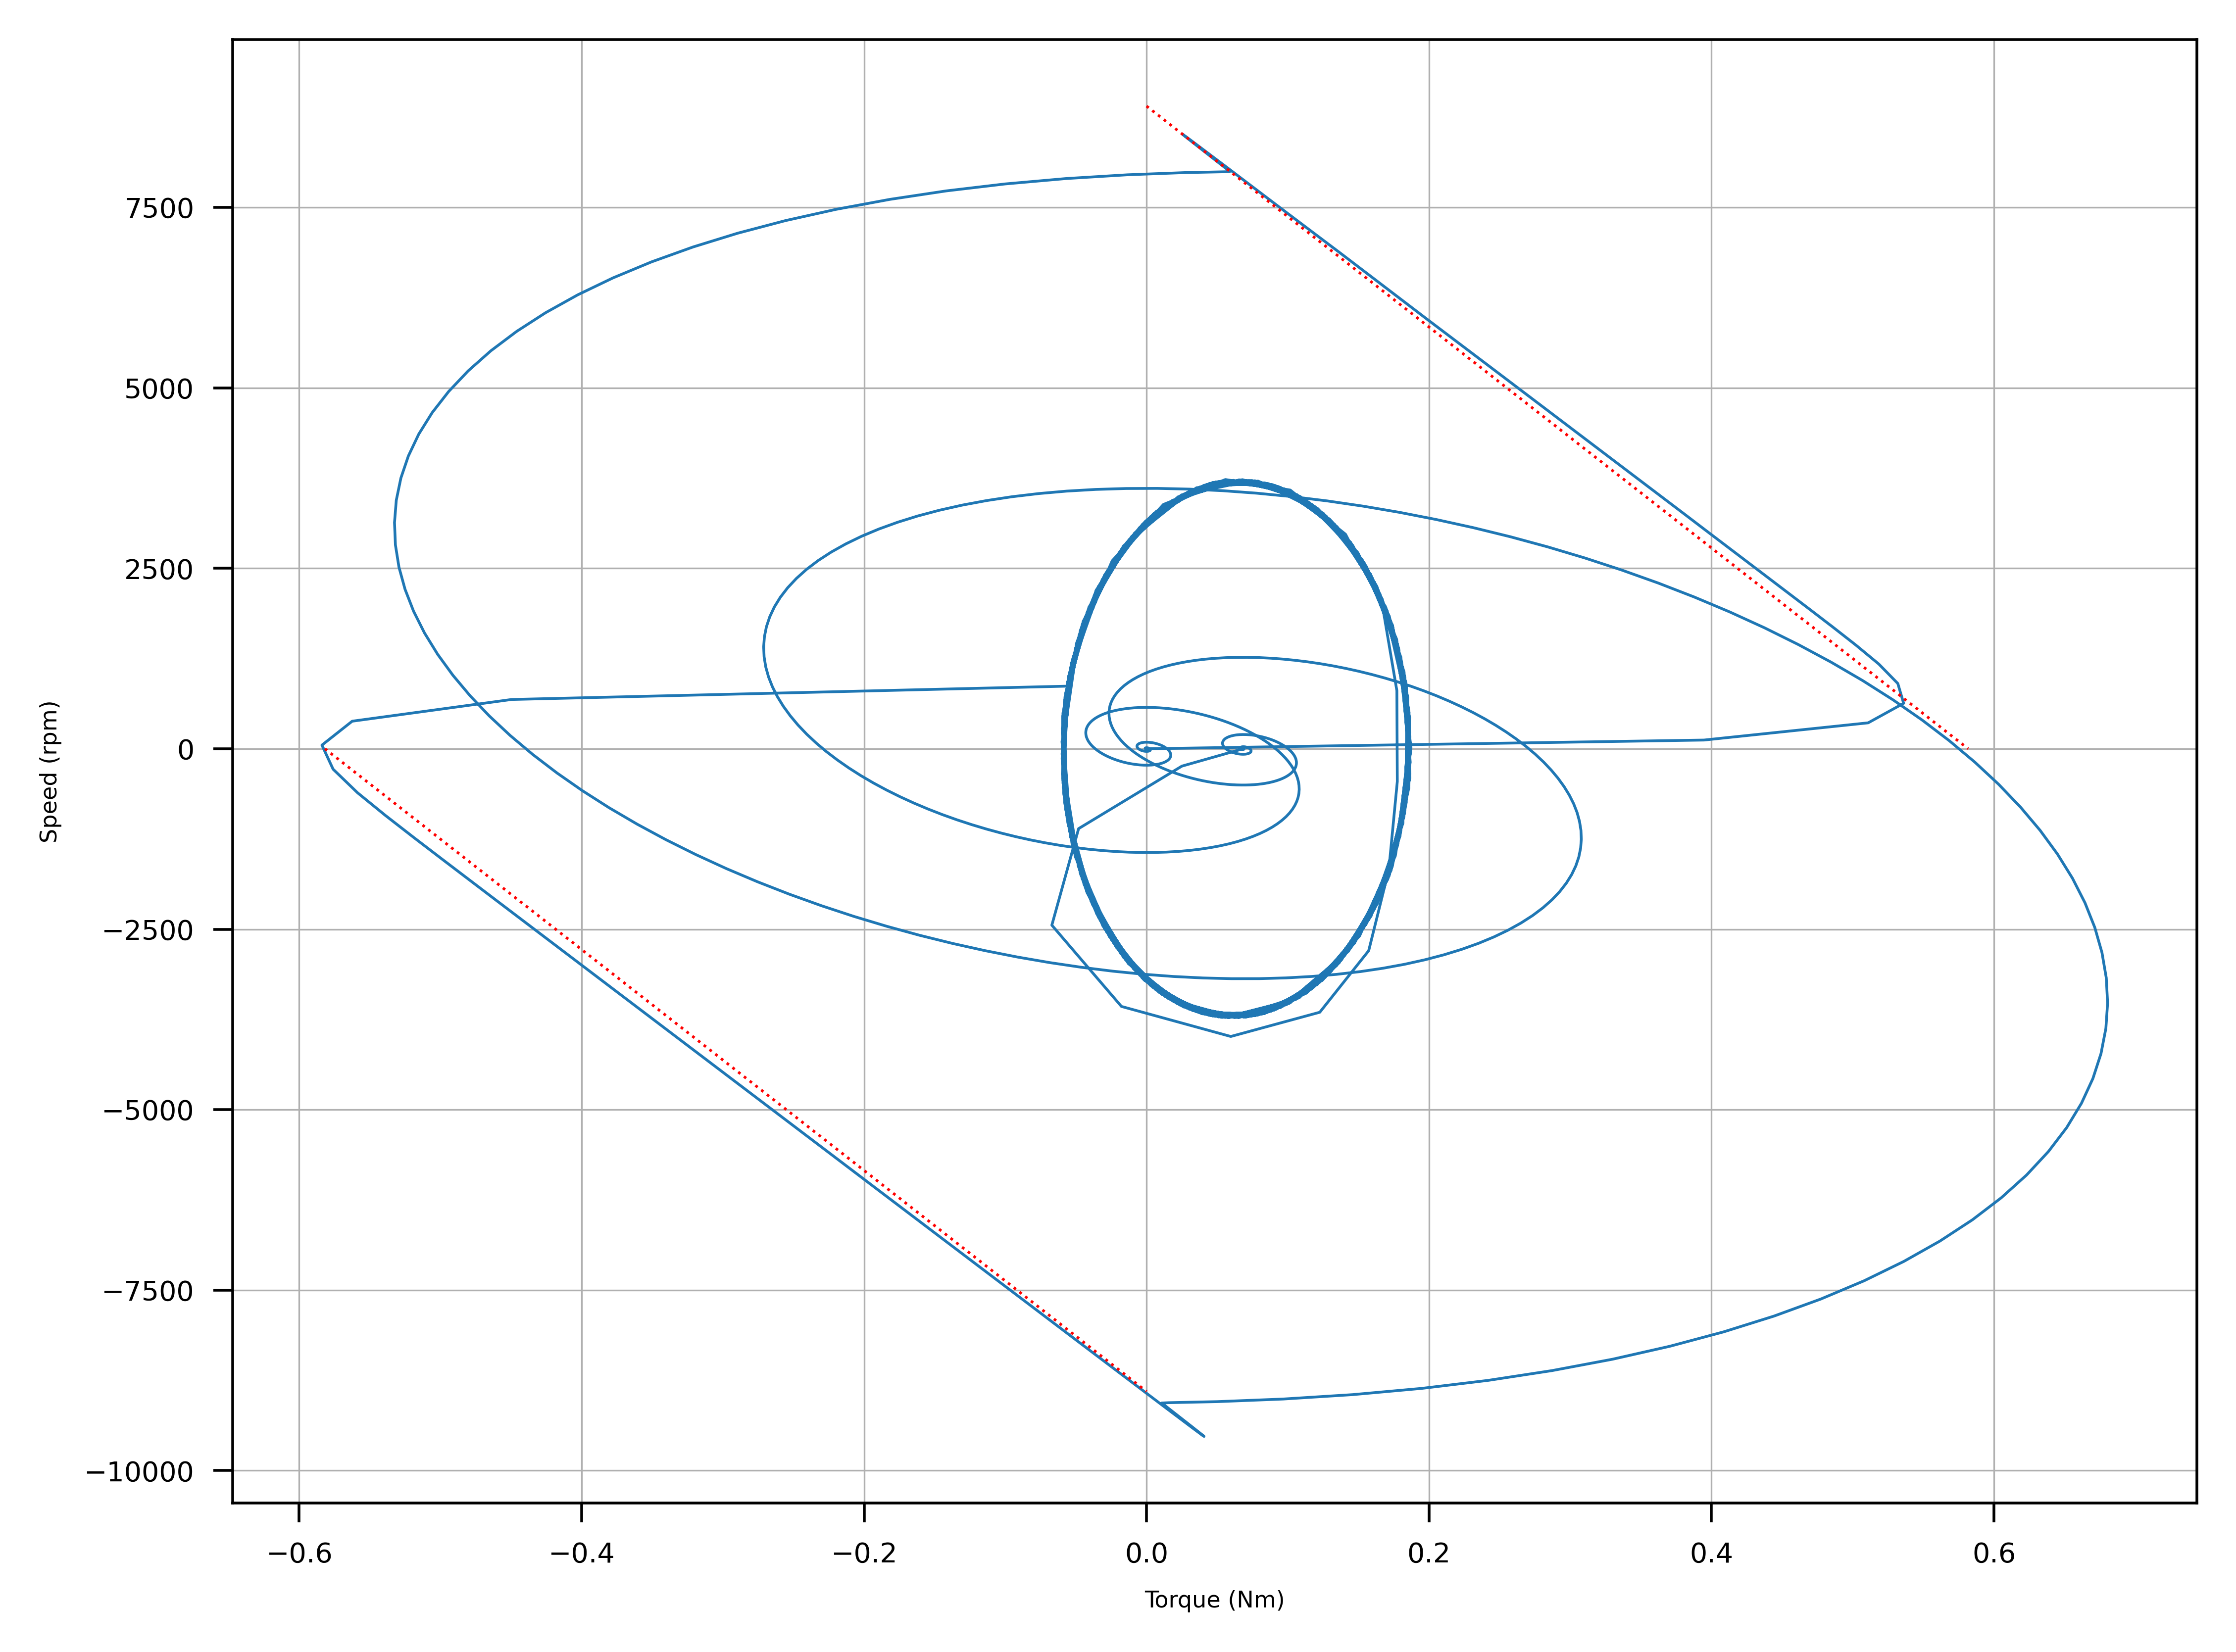

In [12]:
fig,ax = plt.subplots()
ax.plot(y[1]*k_T,y[3]*60 / (2*pi))
x = np.linspace(0 , k_T*U_max/r_a, 100)
xx = np.linspace(-k_T*U_max/r_a, 0, 100)
ax.plot(x, ((U_max / k_T) - (x / k_T**2) * r_a) * 60/(2*pi), linestyle='dotted', color = 'red')
ax.plot(xx, (-(U_max / k_T) - (xx / k_T**2) * r_a) * 60/(2*pi), linestyle='dotted', color = 'red')
ax.set_ylabel('Speed (rpm)')
ax.set_xlabel('Torque (Nm)')
ax.grid()

# Thermal Modelling

Winding heat generated is proportional to current in windings. Lumped mass model of windings and housing. Winding / housing thermal properties and heat transfer coefficient to environment taken from motor datasheets.

Effect of winding resistance is included in this analysis.

In [13]:
current = y[1]
current_t = t
T_ambient = 85
def f(t,y):
    I = np.interp(t, current_t, current)
    heat_gen = I**2 * r_a * (1+alpha_cu*(y[0]-25))
    return [(1/C_w)*(heat_gen - (1/r_w)*(y[0]-y[1])),
           (1/C_h)*((1/r_w)*(y[0]-y[1]) - (1/r_h)*(y[1]-T_ambient))]

sol = sp.integrate.solve_ivp(f,[0,r.t[-1]], [T_ambient,T_ambient], max_step = r.t[-1]/ len(r.t), method = 'Radau')
print(len(sol.t)) 

1086


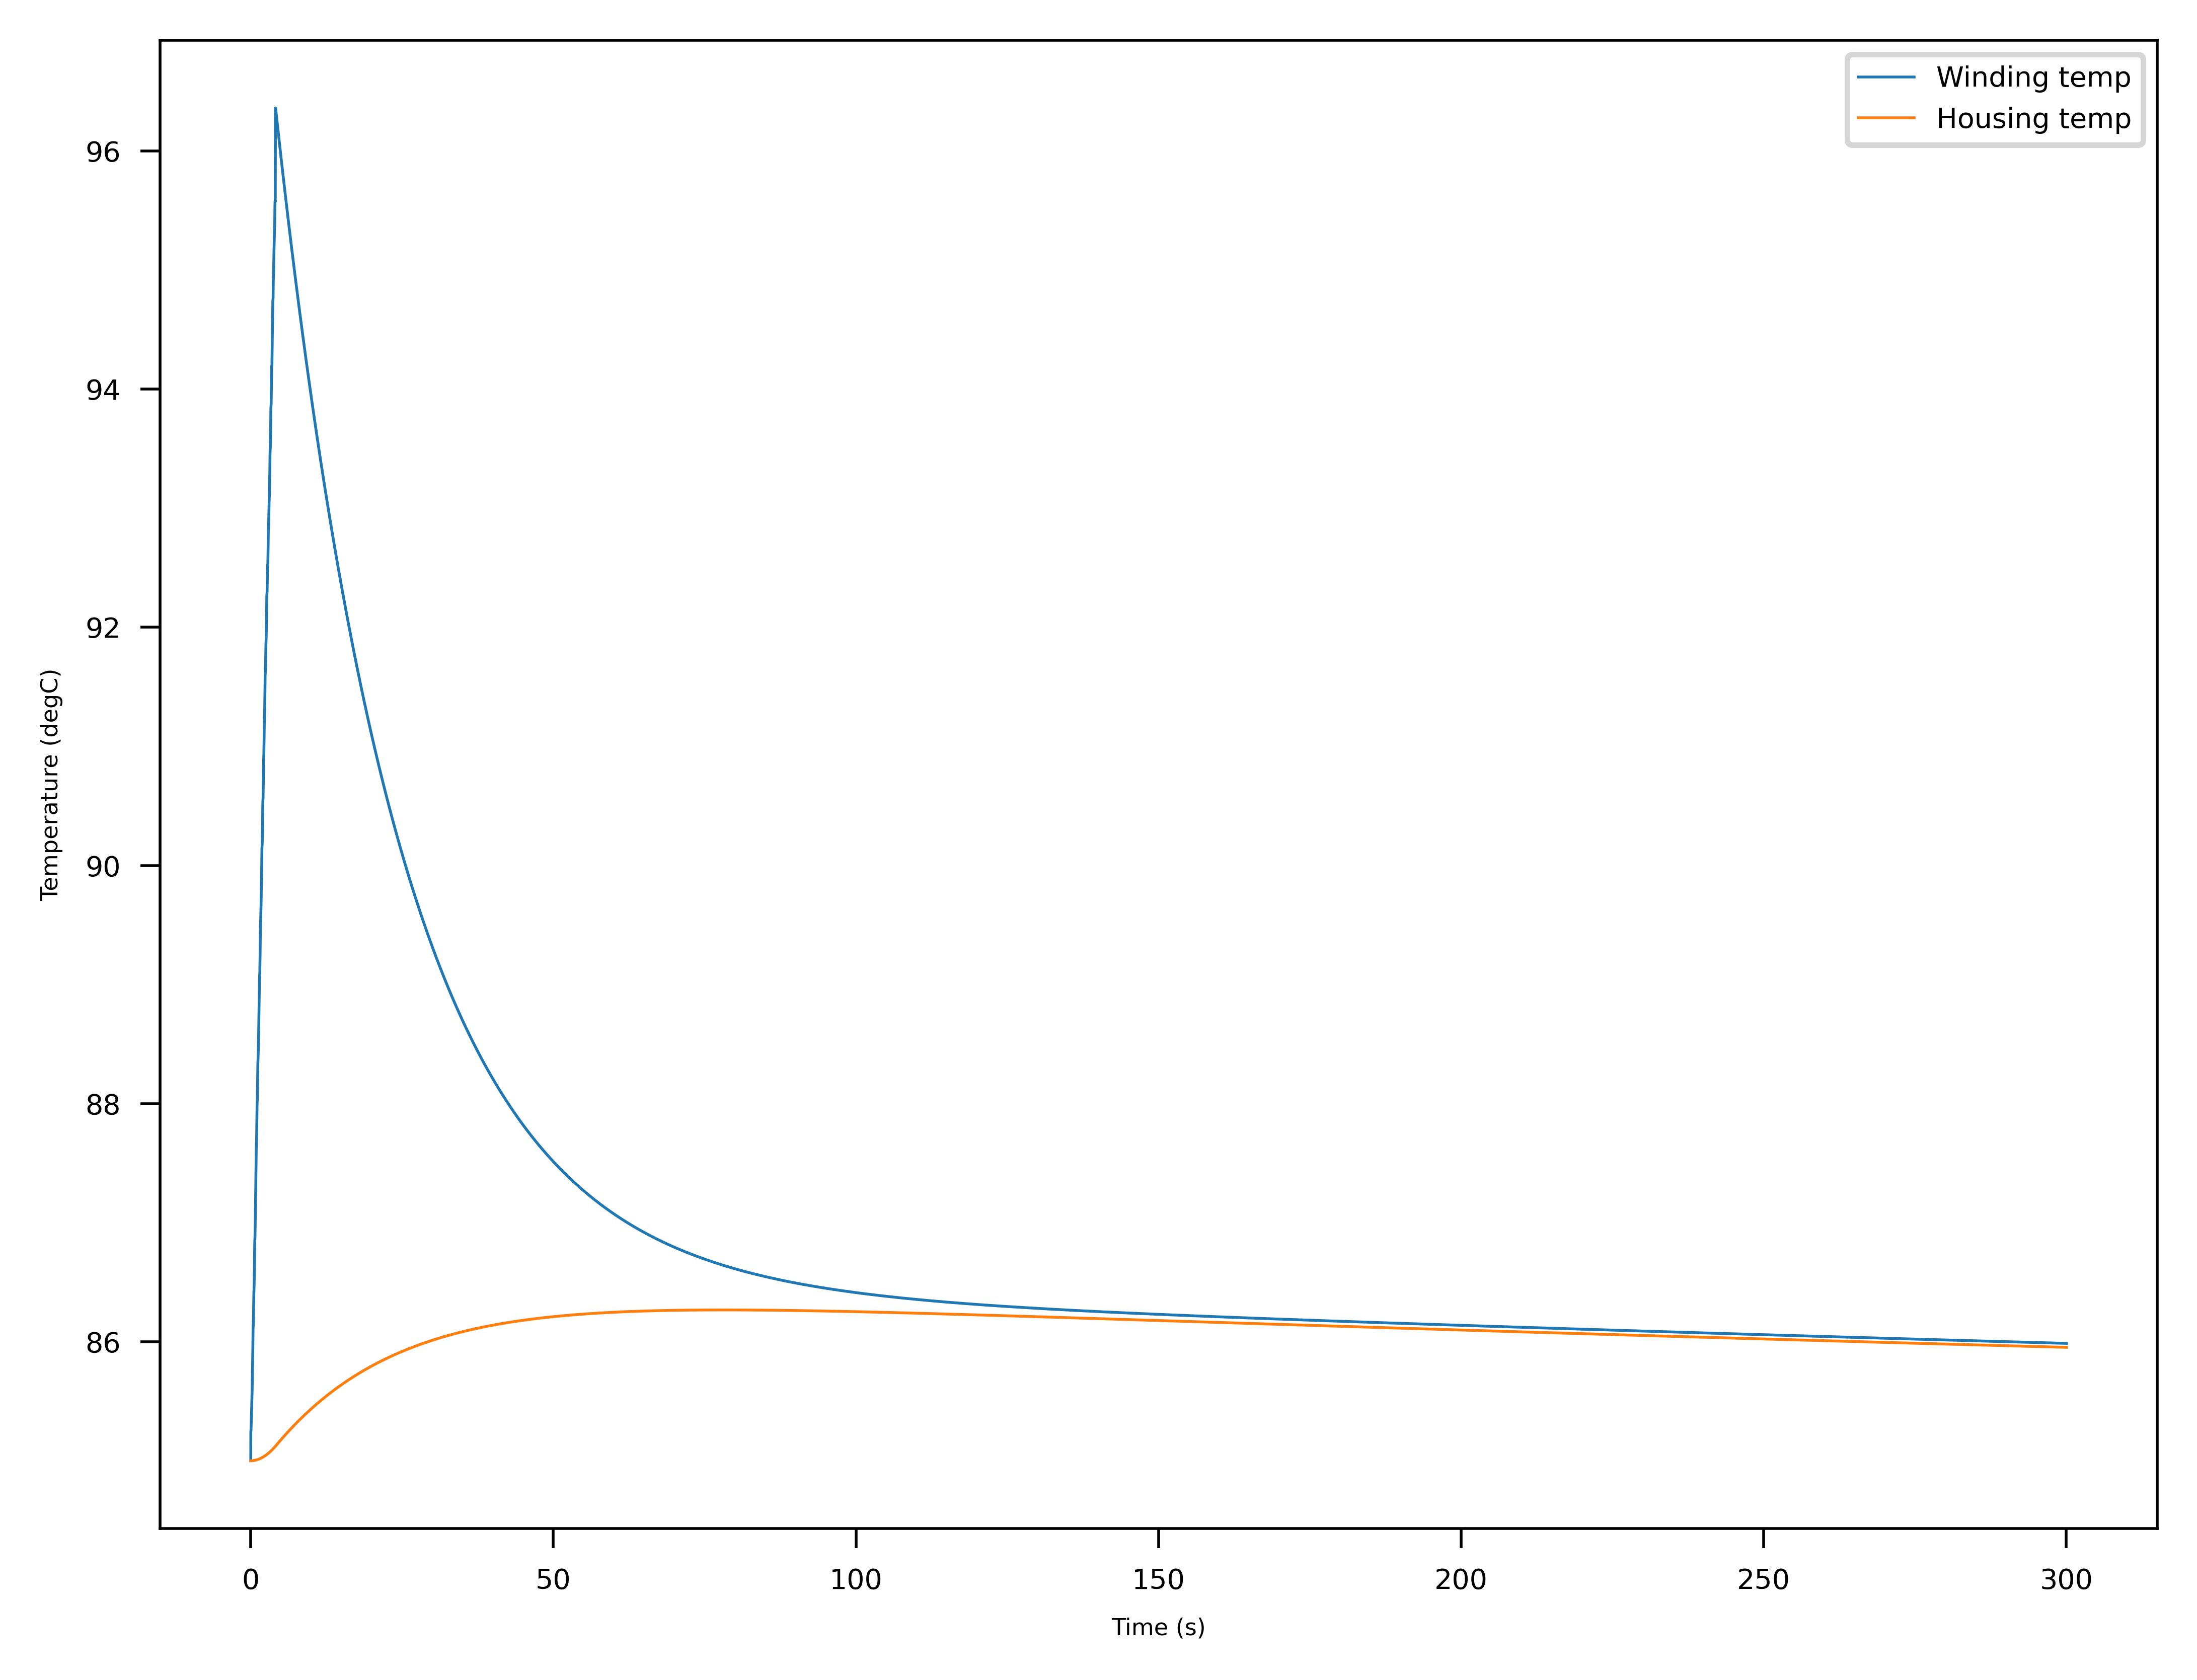

In [14]:
fig,ax = plt.subplots()
ax.plot(sol.t,sol.y[0], label = "Winding temp")
ax.plot(sol.t,sol.y[1], label = "Housing temp")
ax.set_ylabel("Temperature (degC)")
ax.set_xlabel("Time (s)")
ax.legend()